## Data exploration

In [2]:
## Helper functions

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
from skimage.feature import hog

# Visualizations will be shown in the notebook.
%matplotlib inline

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color_space(image,  color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)      
    
    max_value = np.max(feature_image)
    
    if max_value < 1.0001:
        # Image values in range 0..1
        feature_image = feature_image * 255
    
    return feature_image
    

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, hog_color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                        spatial_color_space='RGB', spatial_color_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        feature_image = convert_color_space(image, spatial_color_space)

        if spatial_feat == True:
            if spatial_color_channel == 'ALL':
                spatial_features = bin_spatial(feature_image, size=spatial_size)
            else:
                spatial_features = bin_spatial(feature_image[:,:,spatial_color_channel], size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
            hog_image = convert_color_space(image, hog_color_space)

            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(hog_image.shape[2]):
                    hog_features.append(get_hog_features(hog_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(hog_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


./data/cars/40.png
(64, 64)
(64, 64)
(64, 64)
(64, 64)


C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(64, 64)
(64, 64)
(64, 64)


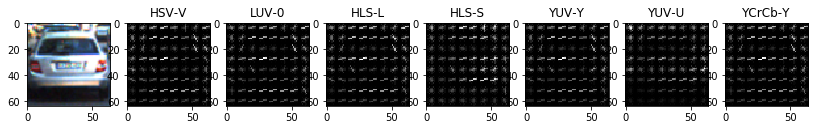

./data/cars/129.png
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


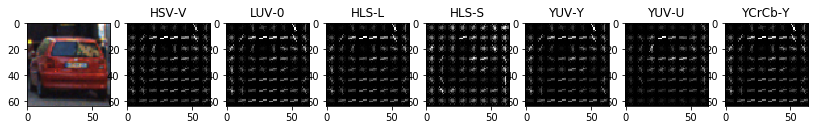

./data/cars/625.png
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


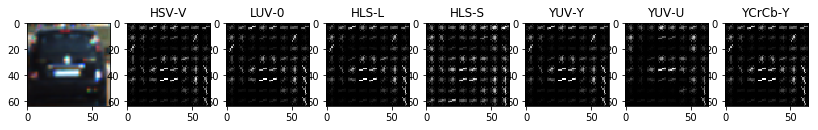

./data/cars/777.png
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


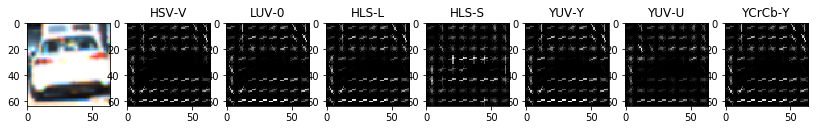

In [3]:
def hog_test(rgbImage, color_space='RGB', channel=0, orient=9, 
                        pix_per_cell=8, cell_per_block=2):
    if color_space != 'RGB':
        if color_space == 'HSV':
            input_image = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            input_image = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            input_image = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            input_image = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            input_image = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2YCrCb)
        else: 
            input_image = np.copy(rgbImage)
        
        input_image = input_image[:,:, channel]
    else:
        input_image = cv2.cvtColor(rgbImage, cv2.COLOR_RGB2GRAY)
        
    
    features, hog_image = get_hog_features(input_image, orient, pix_per_cell, cell_per_block, vis=True)    
    
    return input_image, hog_image

def do_tests(fname):
    print(fname)
    
    plt.rcParams["figure.figsize"] = [14, 4]
    
    
    image = mpimg.imread(fname)
    plt.subplot(181)
    plt.imshow(image)
    
    inp, hog = hog_test(image, "HSV", 2)
    plt.subplot(182)
    plt.title("HSV-V")
    plt.imshow(hog, cmap="gray")
    
    inp, hog = hog_test(image, "LUV", 0)
    plt.subplot(183)
    plt.title("LUV-0")
    plt.imshow(hog, cmap="gray")
    
    inp, hog = hog_test(image, "HLS", 1)
    plt.subplot(184)
    plt.title("HLS-L")
    plt.imshow(hog, cmap="gray")
    
    inp, hog = hog_test(image, "HLS", 2)
    plt.subplot(185)
    plt.title("HLS-S")
    plt.imshow(hog, cmap="gray")
    
    inp, hog = hog_test(image, "YUV", 0)
    plt.subplot(186)
    plt.title("YUV-Y")
    plt.imshow(hog, cmap="gray")
    
    inp, hog = hog_test(image, "YUV", 1)
    plt.subplot(187)
    plt.title("YUV-U")
    plt.imshow(hog, cmap="gray")
    
    inp, hog = hog_test(image, "YCrCb", 0)
    plt.subplot(188)
    plt.title("YCrCb-Y")
    plt.imshow(hog, cmap="gray")
    plt.show()
    
do_tests("./data/cars/40.png")

do_tests("./data/cars/129.png")

do_tests("./data/cars/625.png")

do_tests("./data/cars/777.png")
    
    
            
    

./data/cars/40.png
0.481363


C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:190: RuntimeWarning: invalid value encountered in remainder
  orientations, orientation_histogram)


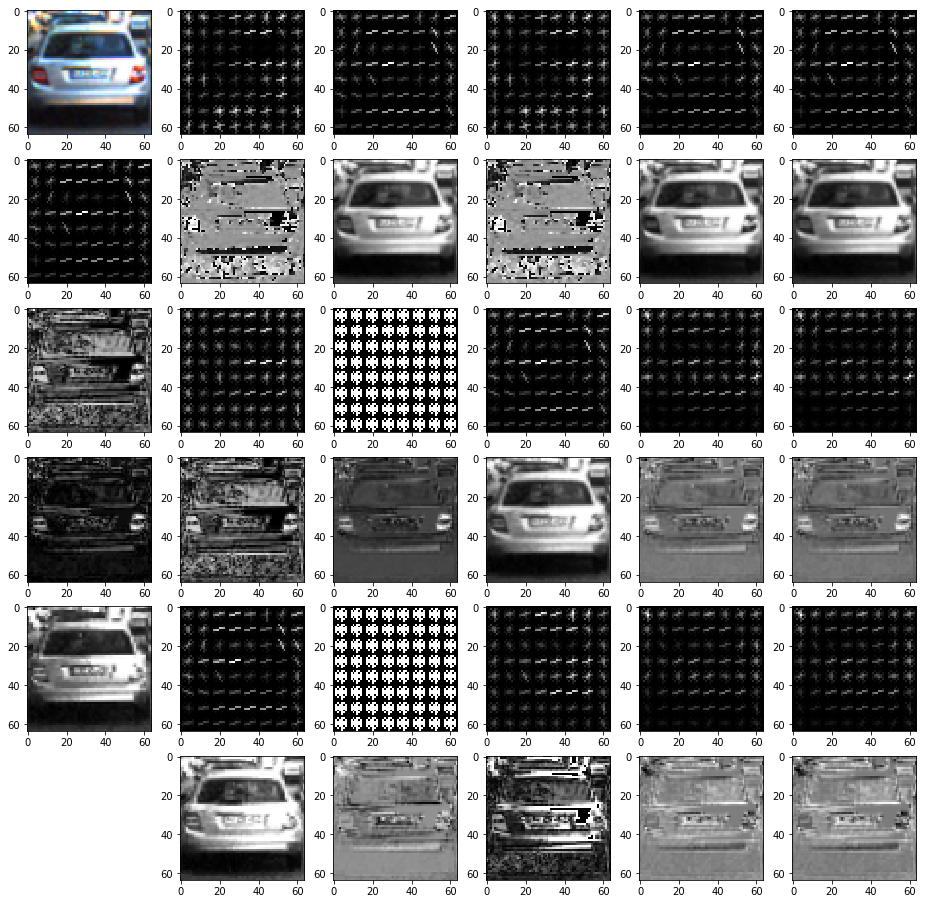

In [100]:
def do_tests2(fname):
    print(fname)
    
    plt.rcParams["figure.figsize"] = [16, 16]
    color_spaces=["HSV", "LUV", "HLS","YUV", "YCrCb"]
    
    image = mpimg.imread(fname)
    plt.subplot(661)
    plt.imshow(image)
    
    inp, hog = hog_test(image, "RGB", 0)
    plt.subplot(667)
    plt.imshow(hog, cmap="gray")
    
    h =  cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
    plt.subplot(6,6, 13)
    plt.imshow(h, cmap="gray")
    
    cr = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)[:,:,1]
    crm = np.mean(cr)
    print(crm)
    df = np.absolute(cr-crm)
    dn = df * 255/np.max(df)
    
    
    plt.subplot(6,6, 19)
    plt.imshow(dn, cmap="gray")
    
    plt.subplot(6,6, 25)
    plt.imshow(image[:,:,0], cmap="gray")
    
    for i in range(3):
        for j in range(5):
            inp, hog = hog_test(image, color_spaces[j], i)
            plt.subplot(6,6, (i*2)*6 + j + 2)
            plt.imshow(hog, cmap="gray")
            plt.subplot(6,6, (i*2)*6 + j + 8)
            plt.imshow(inp, cmap="gray")
            
    plt.show()        
    
    
do_tests2("./data/cars/40.png")

./data/cars/129.png
0.547364


C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:190: RuntimeWarning: invalid value encountered in remainder
  orientations, orientation_histogram)


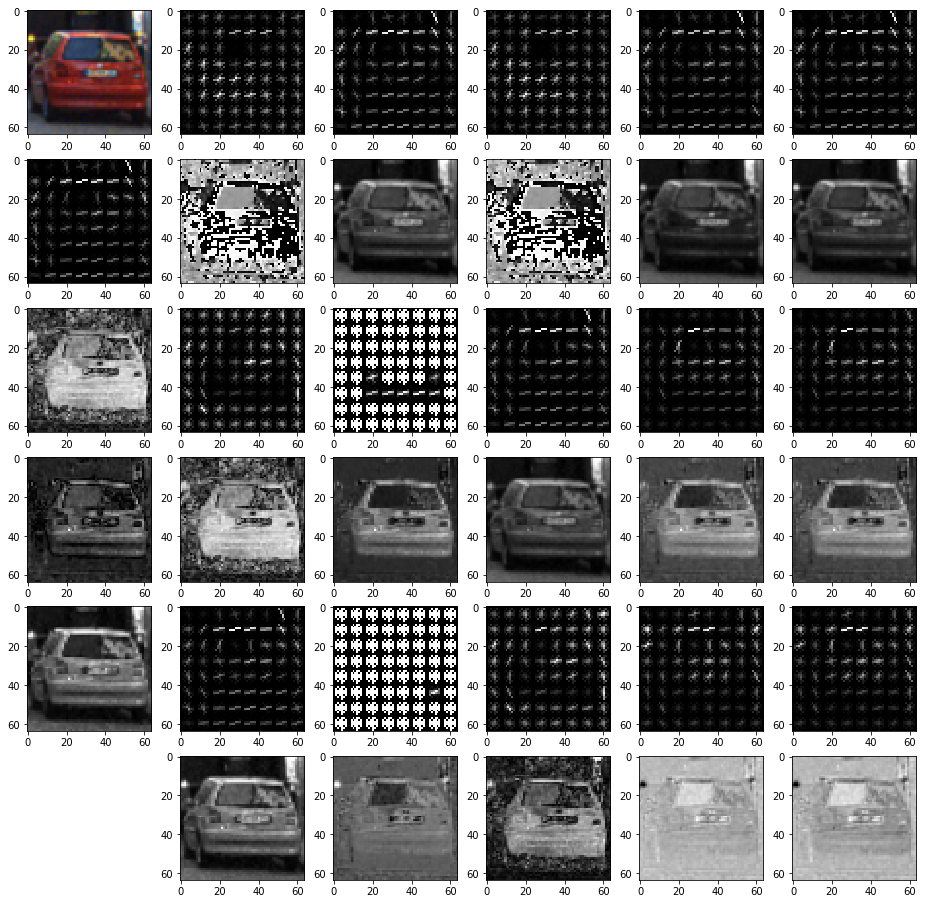

In [101]:
do_tests2("./data/cars/129.png")

./data/cars/625.png
0.492076


C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:190: RuntimeWarning: invalid value encountered in remainder
  orientations, orientation_histogram)


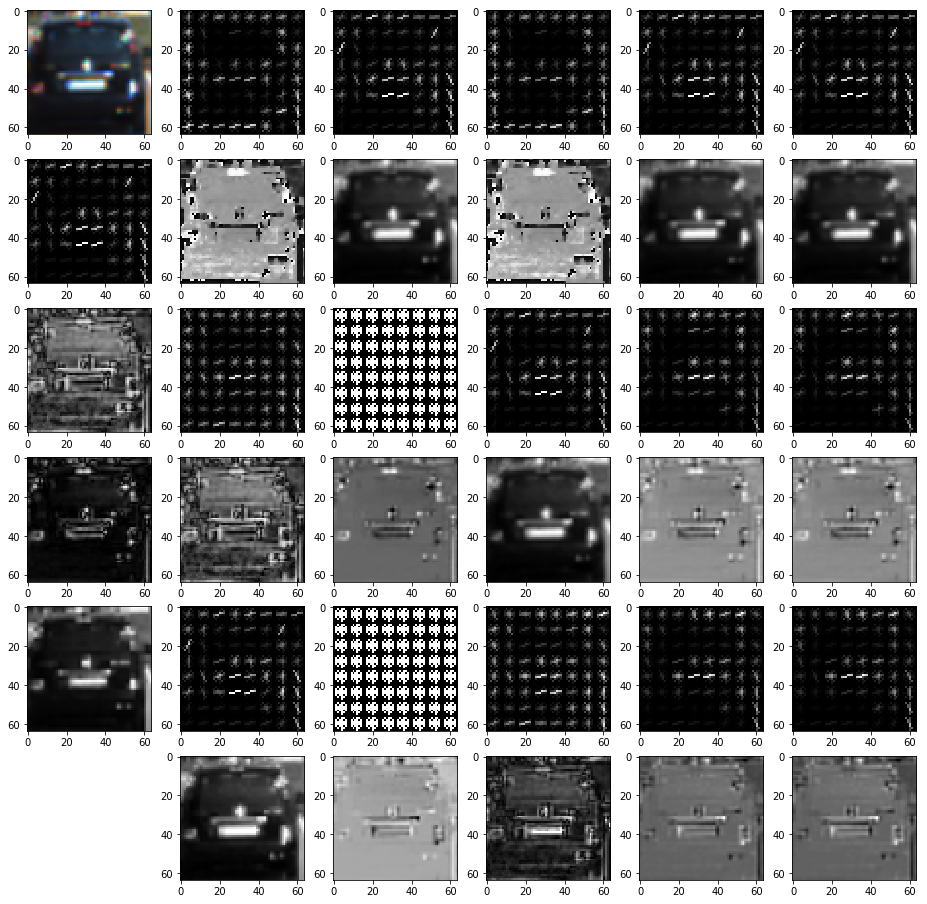

In [102]:
do_tests2("./data/cars/625.png")

./data/cars/777.png
0.495326


C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:190: RuntimeWarning: invalid value encountered in remainder
  orientations, orientation_histogram)


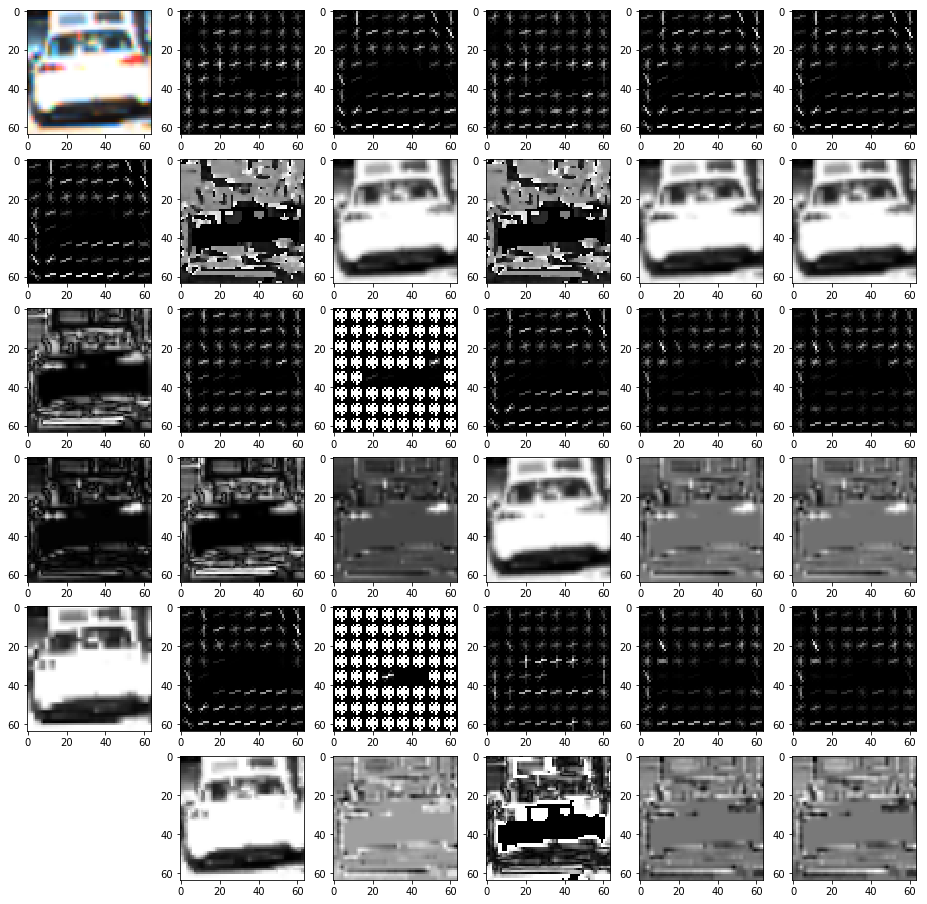

In [103]:
do_tests2("./data/cars/777.png")  

./data/cars/2091.png
0.450907


C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
C:\Users\Victor\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:190: RuntimeWarning: invalid value encountered in remainder
  orientations, orientation_histogram)


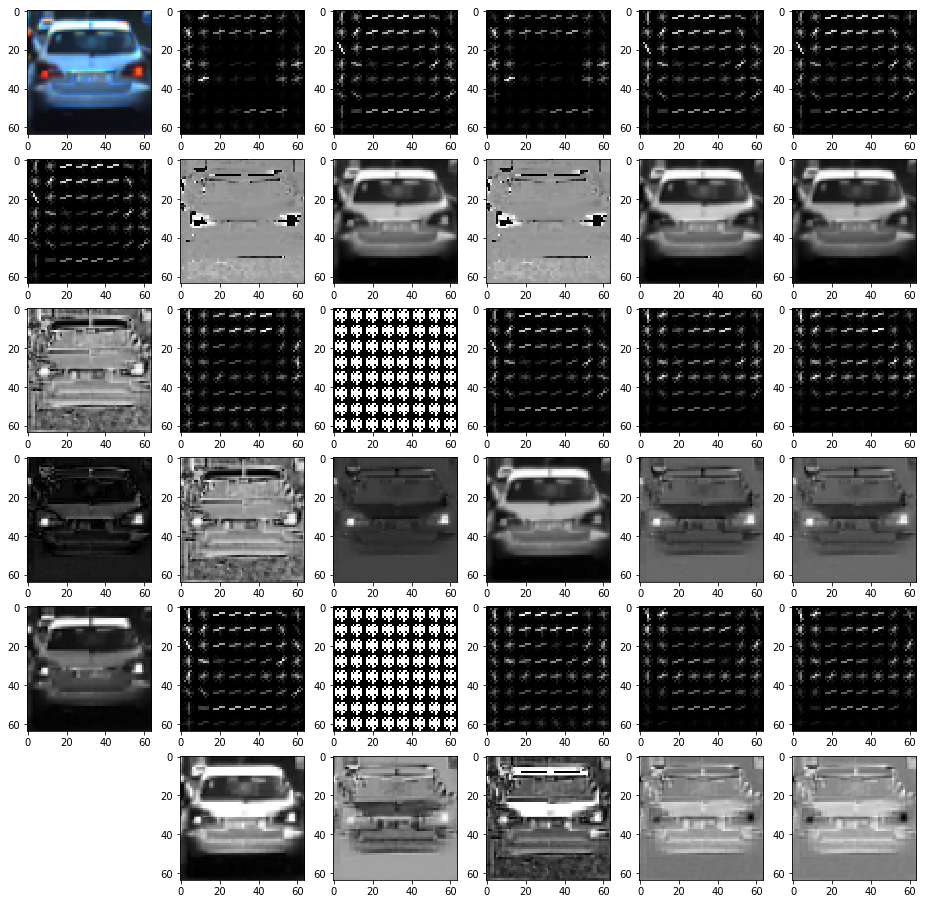

In [104]:
do_tests2("./data/cars/2091.png")  